In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd

# Crear una instancia del cliente BigQuery usando el archivo de credenciales JSON
credentials_path = 'C:/Users/NoxiePC/Desktop/henry/driven-atrium-445021-m2-a773215c2f46.json'
credentials = service_account.Credentials.from_service_account_file(credentials_path)

# Crear el cliente BigQuery con las credenciales
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Definir la consulta SQL para acceder a la vista
query_viajes_por_ubicacion_y_tiempo = """
SELECT *
FROM `driven-atrium-445021-m2.project_data.viajes_por_ubicacion_y_tiempo`
"""
query_weather_borough_details = """
SELECT *
FROM `driven-atrium-445021-m2.project_data.weather_borough_details`
"""
query_coordinates = """
SELECT *
FROM driven-atrium-445021-m2.project_data.coordinates
"""

# Ejecutar la consulta y cargar los resultados en un DataFrame de pandas
df_coordinates = client.query(query_coordinates).to_dataframe()
df_clima = client.query(query_weather_borough_details).to_dataframe()
df_viajes = client.query(query_viajes_por_ubicacion_y_tiempo).to_dataframe()

c:\Users\NoxiePC\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1785: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
c:\Users\NoxiePC\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1785: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
c:\Users\NoxiePC\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1785: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [2]:
clima = df_clima

In [3]:
fechas = clima[['year', 'month', 'day_of_month', 'day_of_week', 'hour_of_day']]
fechas = fechas.loc[fechas.index.repeat(261)].reset_index(drop=True)

In [4]:
unique_location_ids = df_viajes['location_id'].unique()
repeated_location_ids = list(unique_location_ids) * (len(fechas) // len(unique_location_ids)) + list(unique_location_ids)[:(len(fechas) % len(unique_location_ids))]

# Agregar la columna 'location_id' a fechas
fechas['location_id'] = repeated_location_ids

In [5]:
viajes = df_viajes

In [6]:
# Combinar los datasets en función de la columna "location_id" 
fechas = pd.merge(fechas, df_coordinates[['location_id', 'borough']], on='location_id', how='left')
resultado = pd.merge(fechas, clima, on=['borough', 'year', 'month', 'day_of_month', 'hour_of_day', 'day_of_week'])

In [7]:
# Combinar los datasets en función de las columnas relevantes
clima_con_viajes = pd.merge(resultado, viajes[['location_id', 'year', 'month', 'day_of_month', 'day_of_week', 'hour_of_day', 'cantidad_de_viajes']],
                            on=['location_id', 'year', 'month', 'day_of_month', 'day_of_week', 'hour_of_day'], 
                            how='left')

# Rellenar los valores nulos en la columna 'cantidad_de_viajes' con ceros utilizando una asignación directa
clima_con_viajes['cantidad_de_viajes'] = clima_con_viajes['cantidad_de_viajes'].fillna(0)


Cross-Validation MSE: 129.30524772755774 ± 12.626092832542755
Mean Squared Error (MSE): 107.22398385044399
Mean Absolute Error (MAE): 5.652019289906179
R² Score: 0.9925643181574633
Importancia de las Características:
location_id             0.581515
hour_of_day             0.207263
day_of_week             0.103121
weather_code            0.015278
wind_gusts              0.015177
cloud_cover             0.014988
temperature             0.013909
apparent_temperature    0.012843
wind_speed              0.012313
day_of_month            0.012191
relative_humidity       0.011402
dtype: float32


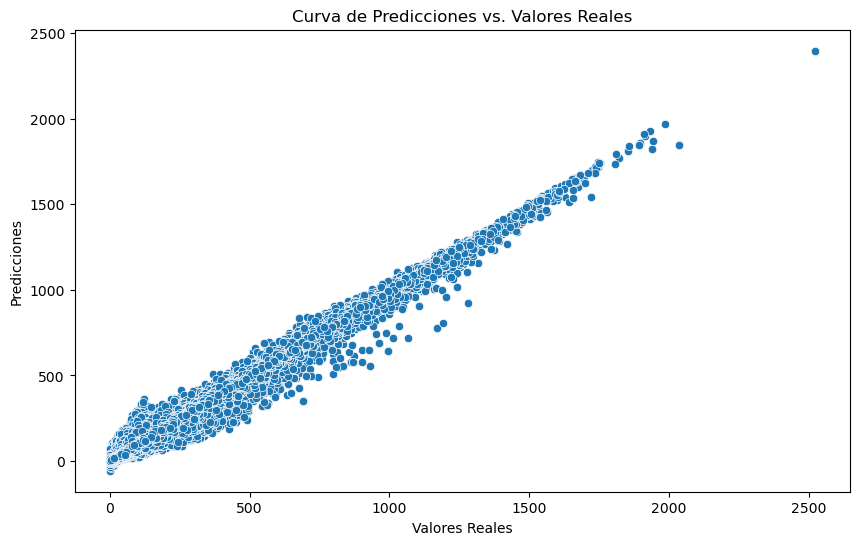

In [62]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Variables predictoras (X) y variable objetivo (y)
predictors = [
    'location_id', 'day_of_month','hour_of_day', 'day_of_week',
    'relative_humidity', 'apparent_temperature','temperature', 'weather_code',
    'cloud_cover','wind_speed', 'wind_gusts'
]
X = clima_con_viajes[predictors]
y = clima_con_viajes['cantidad_de_viajes']

# Dividir los datos en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo XGBoost
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=20,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Validación cruzada para evaluar el modelo
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE: {-scores.mean()} ± {scores.std()}")

# Predecir con los datos de prueba
y_pred = model.predict(X_test)


Cross-Validation MSE: 398.4454879809412 ± 11.331014240687766
Mean Squared Error (MSE): 406.5076946072976
Mean Absolute Error (MAE): 11.730662029790672
R² Score: 0.9718072284758285
Importancia de las Características:
location_id             0.466159
hour_of_day             0.280184
day_of_week             0.138278
weather_code            0.016424
wind_gusts              0.016072
cloud_cover             0.015264
temperature             0.014779
wind_speed              0.013565
relative_humidity       0.013528
apparent_temperature    0.013377
day_of_month            0.012369
dtype: float32


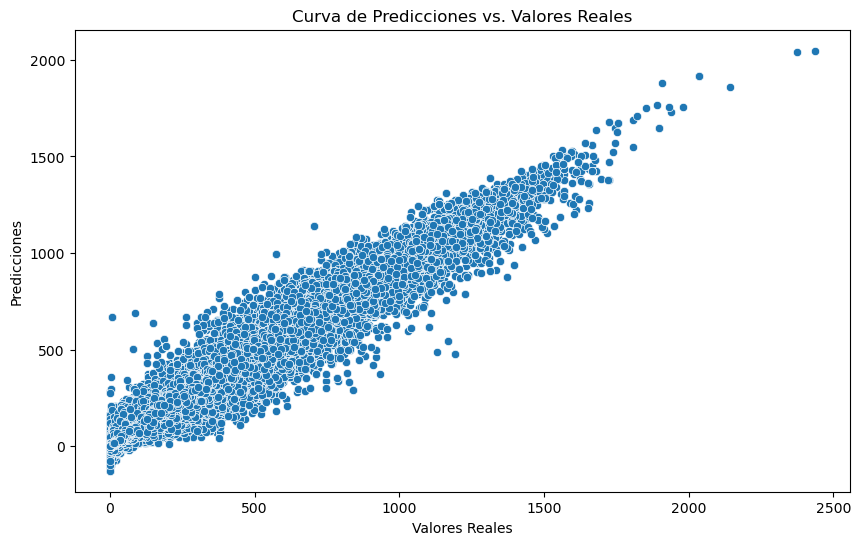

In [53]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Variables predictoras (X) y variable objetivo (y)
predictors = [
    'location_id', 'day_of_month','hour_of_day', 'day_of_week',
    'relative_humidity', 'apparent_temperature','temperature', 'weather_code',
    'cloud_cover','wind_speed', 'wind_gusts'
]
X = clima_con_viajes[predictors]
y = clima_con_viajes['cantidad_de_viajes']

# Dividir los datos en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo XGBoost
model = xgb.XGBRegressor(
    n_estimators=80,
    max_depth=15,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    reg_alpha=0.1, # Regularización L1 
    reg_lambda=0.1, # Regularización L2 
    gamma=1 # Podar árboles que no mejoren la pérdida
)

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Validación cruzada para evaluar el modelo
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE: {-scores.mean()} ± {scores.std()}")

# Predecir con los datos de prueba
y_pred = model.predict(X_test)
# --------------------------- Evaluación del modelo CON 3.14M de DATOS ------------------------------------- #
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

importancia_caracteristicas = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
print("Importancia de las Características:")
print(importancia_caracteristicas)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Curva de Predicciones vs. Valores Reales")
plt.show()